### Capstone Project: Predicting MLB Player Salary - Pitchers

Imports

In [286]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import requests
from bs4 import BeautifulSoup
pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000

In [287]:
batting = pd.read_csv('Batting.csv')
pitching = pd.read_csv('Pitching.csv')
salaries = pd.read_csv('Salaries.csv')
all_star = pd.read_csv('AllStarFull.csv')
awards = pd.read_csv('AwardsPlayers.csv') 

In [288]:
url = 'https://www.baseball-reference.com/friv/fieldPitch.shtml'
res = requests.get(url)

In [289]:
res.status_code

200

In [290]:
soup = BeautifulSoup(res.content, 'lxml')

In [291]:
table = soup.find('table', {'id': 'pitching'})
type(table)

bs4.element.Tag

In [292]:
players = []

for row in table.find_all('tr')[1:]:
    player = {}
    player['name'] = row.find('a').text
    player['playerID'] = row.find('td').attrs['data-append-csv']
    players.append(player)
pos_players_pitching = pd.DataFrame(players)

In [293]:
pos_players_pitching.head()

,name,playerID
0,Charlie Abbey,abbeych01
1,Ehire Adrianza,adriaeh01
2,Eddie Ainsmith,ainsmed01
3,Hanser Alberto,alberha01
4,Mike Aldrete,aldremi01


### Data Cleaning For Pitchers

In [294]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78,43,23,0,11,1,NaN,7.96,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792,361,132,4,37,13,NaN,4.50,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3,8,3,0,0,0,NaN,27.00,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639,295,103,3,31,15,NaN,4.35,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27,20,10,0,3,0,NaN,10.00,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [295]:
pitching.tail()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
47623,zamorda01,2019,1,NYN,NL,0,1,17,0,0,0,0,26,10,5,1,5,8,0.294,5.19,1.0,0,1.0,0,41.0,3,5,0.0,1.0,0.0
47624,zeuchtj01,2019,1,TOR,AL,1,2,5,3,0,0,0,68,22,12,2,11,20,0.250,4.76,0.0,2,0.0,0,99.0,0,13,0.0,0.0,1.0
47625,zimmejo02,2019,1,DET,AL,1,13,23,23,0,0,0,336,145,86,19,25,82,0.311,6.91,2.0,3,6.0,0,504.0,0,89,3.0,4.0,5.0
47626,zimmeky01,2019,1,KCA,AL,0,1,15,0,0,0,0,55,28,22,2,19,18,0.337,10.80,0.0,2,0.0,0,102.0,3,22,0.0,0.0,1.0
47627,zobribe01,2019,1,CHN,NL,0,0,1,0,0,0,0,3,0,0,0,2,1,0.000,0.00,0.0,0,0.0,0,5.0,1,0,0.0,0.0,0.0


In [296]:
pitching.shape

(47628, 30)

In [297]:
# Removing Position Players from pitching stats data
# Code inspired from https://stackoverflow.com/questions/54219055/how-to-remove-rows-from-pandas-dataframe-if-the-same-row-exists-in-another-dataf
hitters = pos_players_pitching[['playerID']]
df_temp = pitching.merge(hitters, on='playerID', how='outer', indicator=True)
pitchers = df_temp[df_temp["_merge"] == "left_only"].drop(columns=["_merge"])

In [298]:
pitchers

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
5,brainas01,1871.0,1.0,WS3,NaN,12.0,15.0,30.0,30.0,30.0,0.0,0.0,792.0,361.0,132.0,4.0,37.0,13.0,NaN,4.50,NaN,7.0,NaN,0.0,1291.0,0.0,292.0,NaN,NaN,NaN
6,brainas01,1872.0,1.0,WS3,NaN,2.0,7.0,9.0,9.0,9.0,0.0,0.0,237.0,148.0,56.0,0.0,5.0,1.0,NaN,6.38,NaN,12.0,NaN,0.0,449.0,0.0,140.0,NaN,NaN,NaN
7,brainas01,1872.0,2.0,MID,NaN,0.0,2.0,2.0,2.0,1.0,0.0,0.0,24.0,13.0,5.0,1.0,0.0,0.0,NaN,5.63,NaN,0.0,NaN,0.0,50.0,0.0,17.0,NaN,NaN,NaN
8,brainas01,1873.0,1.0,BL1,NaN,5.0,7.0,14.0,14.0,12.0,0.0,0.0,326.0,182.0,50.0,0.0,9.0,3.0,NaN,4.14,NaN,3.0,NaN,0.0,568.0,0.0,139.0,NaN,NaN,NaN
9,brainas01,1874.0,1.0,BL1,NaN,5.0,22.0,30.0,27.0,25.0,0.0,0.0,720.0,405.0,99.0,1.0,27.0,8.0,NaN,3.71,NaN,19.0,NaN,0.0,1267.0,4.0,329.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47622,yardler01,2019.0,1.0,SDN,NL,0.0,1.0,10.0,0.0,0.0,0.0,0.0,35.0,12.0,3.0,1.0,3.0,7.0,0.261,2.31,0.0,0.0,1.0,0.0,52.0,2.0,5.0,2.0,0.0,2.0
47623,ynoahu01,2019.0,1.0,ATL,NL,0.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,6.0,1.0,1.0,3.0,0.400,18.00,0.0,0.0,0.0,0.0,16.0,1.0,6.0,0.0,0.0,0.0
47624,youngal01,2019.0,1.0,ARI,NL,7.0,5.0,17.0,15.0,0.0,0.0,0.0,250.0,72.0,33.0,14.0,27.0,71.0,0.229,3.56,4.0,2.0,4.0,0.0,349.0,0.0,40.0,3.0,0.0,5.0
47625,zeuchtj01,2019.0,1.0,TOR,AL,1.0,2.0,5.0,3.0,0.0,0.0,0.0,68.0,22.0,12.0,2.0,11.0,20.0,0.250,4.76,0.0,2.0,0.0,0.0,99.0,0.0,13.0,0.0,0.0,1.0


In [299]:
# Drop years before 1985 because we do not have salary data before 1985
pitchers = pitchers[pitchers['yearID'] > 1984]
pitchers.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22277.000000,22264.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000,22285.000000
mean,2003.820013,1.088445,3.619340,3.619161,26.205519,7.240117,0.397667,0.130357,1.822840,193.974063,64.497824,30.299349,7.332780,23.776756,48.597308,0.273188,5.353660,1.890958,2.379403,2.258245,0.333094,277.928696,6.826071,33.083195,2.329235,2.026610,5.535383
std,9.900214,0.297379,4.374652,3.795190,20.297382,10.999290,1.330265,0.498981,6.454279,186.665625,61.474377,28.086401,7.443294,21.395570,48.954364,0.073650,5.433802,2.242231,2.745071,2.688828,0.831323,261.760384,11.310070,30.641509,2.862456,2.217965,6.008391
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1996.000000,1.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,49.000000,18.000000,9.000000,2.000000,7.000000,12.000000,0.236000,3.380000,0.000000,0.000000,0.000000,0.000000,74.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,2004.000000,1.000000,2.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.000000,137.000000,44.000000,20.000000,5.000000,18.000000,33.000000,0.266000,4.420000,1.000000,2.000000,1.000000,0.000000,199.000000,2.000000,22.000000,1.000000,1.000000,3.000000
75%,2012.000000,1.000000,5.000000,6.000000,35.000000,12.000000,0.000000,0.000000,0.000000,259.000000,88.000000,42.000000,10.000000,34.000000,69.000000,0.299000,5.860000,3.000000,4.000000,3.000000,0.000000,371.000000,9.000000,46.000000,3.000000,3.000000,8.000000
max,2019.000000,5.000000,27.000000,21.000000,94.000000,40.000000,20.000000,10.000000,62.000000,856.000000,284.000000,145.000000,50.000000,152.000000,372.000000,1.000000,189.000000,18.000000,26.000000,21.000000,16.000000,1231.000000,79.000000,160.000000,22.000000,17.000000,41.000000


In [300]:
pitchers.tail()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
47622,yardler01,2019.0,1.0,SDN,NL,0.0,1.0,10.0,0.0,0.0,0.0,0.0,35.0,12.0,3.0,1.0,3.0,7.0,0.261,2.31,0.0,0.0,1.0,0.0,52.0,2.0,5.0,2.0,0.0,2.0
47623,ynoahu01,2019.0,1.0,ATL,NL,0.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,6.0,1.0,1.0,3.0,0.400,18.00,0.0,0.0,0.0,0.0,16.0,1.0,6.0,0.0,0.0,0.0
47624,youngal01,2019.0,1.0,ARI,NL,7.0,5.0,17.0,15.0,0.0,0.0,0.0,250.0,72.0,33.0,14.0,27.0,71.0,0.229,3.56,4.0,2.0,4.0,0.0,349.0,0.0,40.0,3.0,0.0,5.0
47625,zeuchtj01,2019.0,1.0,TOR,AL,1.0,2.0,5.0,3.0,0.0,0.0,0.0,68.0,22.0,12.0,2.0,11.0,20.0,0.250,4.76,0.0,2.0,0.0,0.0,99.0,0.0,13.0,0.0,0.0,1.0
47626,zimmeky01,2019.0,1.0,KCA,AL,0.0,1.0,15.0,0.0,0.0,0.0,0.0,55.0,28.0,22.0,2.0,19.0,18.0,0.337,10.80,0.0,2.0,0.0,0.0,102.0,3.0,22.0,0.0,0.0,1.0


In [301]:
pitchers = pitchers.merge(salaries)
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000


In [302]:
pitchers.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary
count,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11772.000000,11770.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,1.177300e+04
mean,2001.318271,1.008834,5.229848,5.064470,34.434978,10.415867,0.677822,0.217277,2.895609,271.991166,90.003228,41.391574,9.813387,32.525864,66.722161,0.266533,4.703969,2.646904,3.181177,2.994819,0.472182,388.272658,9.304425,45.281492,3.405079,2.802599,7.721566,1.946763e+06
std,8.852764,0.102252,4.905409,4.077737,20.203596,12.817931,1.728098,0.644128,8.241526,201.956607,66.769888,30.418375,8.081164,22.939411,52.502111,0.053138,3.268284,2.505875,3.060337,2.997432,1.003313,282.059335,13.894079,33.187253,3.241093,2.446909,6.684643,3.207549e+06
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+04
25%,1994.000000,1.000000,1.000000,2.000000,19.000000,0.000000,0.000000,0.000000,0.000000,117.000000,39.000000,18.000000,4.000000,15.000000,27.000000,0.237000,3.340000,1.000000,1.000000,1.000000,0.000000,173.000000,0.000000,19.000000,1.000000,1.000000,3.000000,2.900000e+05
50%,2001.000000,1.000000,4.000000,4.000000,32.000000,2.000000,0.000000,0.000000,0.000000,209.000000,66.000000,30.000000,7.000000,27.000000,54.000000,0.263000,4.200000,2.000000,2.000000,2.000000,0.000000,297.000000,3.000000,33.000000,3.000000,2.000000,6.000000,5.345000e+05
75%,2009.000000,1.000000,8.000000,8.000000,48.000000,22.000000,0.000000,0.000000,1.000000,415.000000,142.000000,66.000000,15.000000,46.000000,93.000000,0.289000,5.290000,4.000000,5.000000,4.000000,1.000000,601.000000,13.000000,72.000000,5.000000,4.000000,11.000000,2.250000e+06
max,2016.000000,4.000000,27.000000,21.000000,94.000000,39.000000,20.000000,10.000000,62.000000,845.000000,284.000000,145.000000,50.000000,152.000000,372.000000,1.000000,108.000000,18.000000,26.000000,21.000000,16.000000,1157.000000,79.000000,160.000000,22.000000,17.000000,41.000000,3.300000e+07


In [303]:
pitchers.isnull().sum()

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
W           0
L           0
G           0
GS          0
CG          0
SHO         0
SV          0
IPouts      0
H           0
ER          0
HR          0
BB          0
SO          0
BAOpp       1
ERA         3
IBB         0
WP          0
HBP         0
BK          0
BFP         0
GF          0
R           0
SH          0
SF          0
GIDP        0
salary      0
dtype: int64

In [304]:
pitchers.dropna(axis=0, inplace=True)

In [305]:
pitchers.isnull().sum()

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
W           0
L           0
G           0
GS          0
CG          0
SHO         0
SV          0
IPouts      0
H           0
ER          0
HR          0
BB          0
SO          0
BAOpp       0
ERA         0
IBB         0
WP          0
HBP         0
BK          0
BFP         0
GF          0
R           0
SH          0
SF          0
GIDP        0
salary      0
dtype: int64

In [306]:
# Minimum MLB Salary in 1985 was $60,000
# Source from https://www.baseball-reference.com/bullpen/Minimum_salary
pitchers = pitchers[pitchers['salary'] >= 60000]
pitchers.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary
count,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,11770.000000,1.177000e+04
mean,2001.318692,1.008836,5.231181,5.065760,34.443500,10.418522,0.677995,0.217332,2.896347,272.060493,90.025573,41.401359,9.815803,32.533900,66.739167,0.266408,4.703969,2.647579,3.181988,2.995582,0.472302,388.370773,9.306797,45.292268,3.405947,2.803314,7.723534,1.946607e+06
std,8.853658,0.102265,4.905323,4.077455,20.199117,12.818485,1.728284,0.644200,8.242447,201.935646,66.763715,30.416049,8.080773,22.936811,52.497992,0.052275,3.268284,2.505837,3.060305,2.997432,1.003413,282.028307,13.895056,33.184592,3.241051,2.446812,6.684357,3.207804e+06
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+04
25%,1994.000000,1.000000,1.000000,2.000000,19.000000,0.000000,0.000000,0.000000,0.000000,117.000000,39.000000,18.000000,4.000000,15.000000,27.000000,0.237000,3.340000,1.000000,1.000000,1.000000,0.000000,173.000000,0.000000,19.000000,1.000000,1.000000,3.000000,2.881250e+05
50%,2001.000000,1.000000,4.000000,4.000000,32.000000,2.000000,0.000000,0.000000,0.000000,209.000000,66.000000,30.000000,7.000000,27.000000,54.000000,0.263000,4.200000,2.000000,2.000000,2.000000,0.000000,297.000000,3.000000,33.000000,3.000000,2.000000,6.000000,5.339500e+05
75%,2009.000000,1.000000,8.000000,8.000000,48.000000,22.000000,0.000000,0.000000,1.000000,415.000000,142.000000,66.000000,15.000000,46.000000,93.000000,0.289000,5.290000,4.000000,5.000000,4.000000,1.000000,601.000000,13.000000,72.000000,5.000000,4.000000,11.000000,2.250000e+06
max,2016.000000,4.000000,27.000000,21.000000,94.000000,39.000000,20.000000,10.000000,62.000000,845.000000,284.000000,145.000000,50.000000,152.000000,372.000000,0.800000,108.000000,18.000000,26.000000,21.000000,16.000000,1157.000000,79.000000,160.000000,22.000000,17.000000,41.000000,3.300000e+07


In [307]:
# Make a years of experience column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.cumcount.html
pitchers['Years_Exp'] = pitchers.groupby('playerID').cumcount()+1 # +1 because the count starts at 0

In [308]:
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1


In [309]:
# Add the all star column
all_star['allStar'] = 1
all_star = all_star[['playerID', 'yearID', 'allStar']]
pitchers = pitchers.merge(all_star, how='left', on=['playerID', 'yearID'])
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,NaN
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,NaN
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,NaN
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,NaN
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,NaN


In [310]:
# Fill NA with 0. 0 = Did not make the all star game
pitchers = pitchers.fillna({'allStar': 0})
pitchers.head(15)

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,0.0
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,0.0
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,0.0
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,0.0
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,0.0
5,niekrph01,1986.0,1.0,CLE,AL,11.0,11.0,34.0,32.0,5.0,0.0,0.0,631.0,241.0,101.0,24.0,95.0,81.0,0.287,4.32,1.0,9.0,6.0,2.0,951.0,1.0,126.0,7.0,2.0,22.0,300000,2,0.0
6,carltst01,1985.0,1.0,PHI,NL,1.0,8.0,16.0,16.0,0.0,0.0,0.0,276.0,84.0,34.0,6.0,53.0,48.0,0.249,3.33,4.0,3.0,0.0,2.0,401.0,0.0,43.0,9.0,1.0,11.0,1075000,1,0.0
7,carltst01,1986.0,1.0,PHI,NL,4.0,8.0,16.0,16.0,0.0,0.0,0.0,249.0,102.0,57.0,15.0,45.0,62.0,0.297,6.18,4.0,3.0,0.0,0.0,393.0,0.0,70.0,2.0,3.0,10.0,1000000,2,0.0
8,carltst01,1986.0,3.0,CHA,AL,4.0,3.0,10.0,10.0,0.0,0.0,0.0,190.0,58.0,26.0,6.0,25.0,40.0,0.252,3.69,0.0,2.0,0.0,1.0,259.0,0.0,30.0,2.0,2.0,11.0,60000,3,0.0
9,carltst01,1988.0,1.0,MIN,AL,0.0,1.0,4.0,1.0,0.0,0.0,0.0,29.0,20.0,18.0,5.0,5.0,5.0,0.408,16.76,1.0,0.0,0.0,2.0,54.0,1.0,19.0,0.0,0.0,0.0,115000,4,0.0


In [311]:
awards = awards[['playerID', 'yearID', 'awardID']]
awards = pd.get_dummies(awards, columns=['awardID'])
# Take out position players only awards
awards = awards[['playerID', 'yearID', 'awardID_ALCS MVP', 'awardID_All-Star Game MVP', 'awardID_Gold Glove', 'awardID_Most Valuable Player', 'awardID_NLCS MVP', 'awardID_Rookie of the Year','awardID_World Series MVP', 'awardID_Cy Young Award', 'awardID_Rolaids Relief Man Award', 'awardID_Pitching Triple Crown', 'awardID_Reliever of the Year Award']]
pitchers = pitchers.merge(awards, how='left', on=['playerID', 'yearID'])
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS MVP,awardID_All-Star Game MVP,awardID_Gold Glove,awardID_Most Valuable Player,awardID_NLCS MVP,awardID_Rookie of the Year,awardID_World Series MVP,awardID_Cy Young Award,awardID_Rolaids Relief Man Award,awardID_Pitching Triple Crown,awardID_Reliever of the Year Award
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [312]:
pitchers = pitchers.fillna({'awardID_ALCS MVP': 0, 'awardID_All-Star Game MVP': 0, 'awardID_Cy Young Award': 0, 'awardID_Gold Glove': 0, 'awardID_Rolaids Relief Man Award': 0, 'awardID_Most Valuable Player': 0, 'awardID_NLCS MVP': 0, 'awardID_Pitching Triple Crown': 0, 'awardID_Rookie of the Year': 0, 'awardID_Reliever of the Year Award': 0, 'awardID_World Series MVP' : 0})
pitchers.isnull().sum()

playerID                              0
yearID                                0
stint                                 0
teamID                                0
lgID                                  0
W                                     0
L                                     0
G                                     0
GS                                    0
CG                                    0
SHO                                   0
SV                                    0
IPouts                                0
H                                     0
ER                                    0
HR                                    0
BB                                    0
SO                                    0
BAOpp                                 0
ERA                                   0
IBB                                   0
WP                                    0
HBP                                   0
BK                                    0
BFP                                   0


In [313]:
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS MVP,awardID_All-Star Game MVP,awardID_Gold Glove,awardID_Most Valuable Player,awardID_NLCS MVP,awardID_Rookie of the Year,awardID_World Series MVP,awardID_Cy Young Award,awardID_Rolaids Relief Man Award,awardID_Pitching Triple Crown,awardID_Reliever of the Year Award
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [314]:
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS MVP,awardID_All-Star Game MVP,awardID_Gold Glove,awardID_Most Valuable Player,awardID_NLCS MVP,awardID_Rookie of the Year,awardID_World Series MVP,awardID_Cy Young Award,awardID_Rolaids Relief Man Award,awardID_Pitching Triple Crown,awardID_Reliever of the Year Award
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA - Pitchers

#### Distributions for Feature Columns

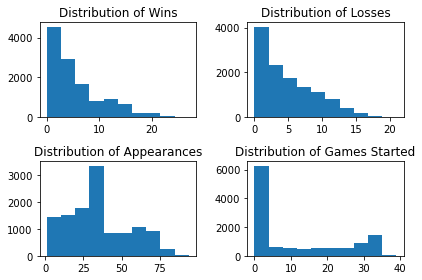

In [447]:
plt.subplot(2,2,1)
plt.hist(pitchers['W'])
plt.title('Distribution of Wins');

plt.subplot(2,2,2)
plt.hist(pitchers['L'])
plt.title('Distribution of Losses');

plt.subplot(2,2,3)
plt.hist(pitchers['G'])
plt.title('Distribution of Appearances');

plt.subplot(2,2,4)
plt.hist(pitchers['GS'])
plt.title('Distribution of Games Started');

plt.tight_layout()
plt.savefig('pitchers1.png')

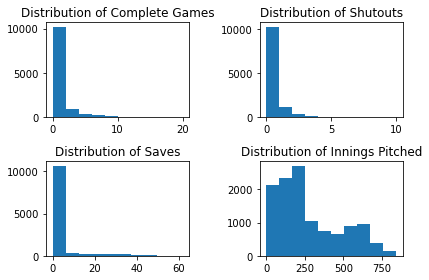

In [448]:
plt.subplot(2,2,1)
plt.hist(pitchers['CG'])
plt.title('Distribution of Complete Games');

plt.subplot(2,2,2)
plt.hist(pitchers['SHO'])
plt.title('Distribution of Shutouts');

plt.subplot(2,2,3)
plt.hist(pitchers['SV'])
plt.title('Distribution of Saves');

plt.subplot(2,2,4)
plt.hist(pitchers['IPouts'])
plt.title('Distribution of Innings Pitched');

plt.tight_layout()
plt.savefig('pitchers2.png')

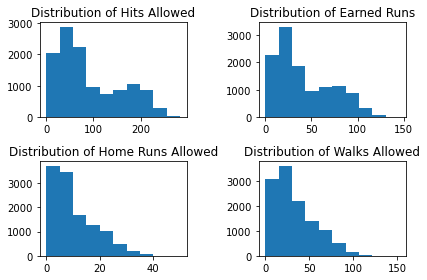

In [449]:
plt.subplot(2,2,1)
plt.hist(pitchers['H'])
plt.title('Distribution of Hits Allowed');

plt.subplot(2,2,2)
plt.hist(pitchers['ER'])
plt.title('Distribution of Earned Runs');

plt.subplot(2,2,3)
plt.hist(pitchers['HR'])
plt.title('Distribution of Home Runs Allowed');

plt.subplot(2,2,4)
plt.hist(pitchers['BB'])
plt.title('Distribution of Walks Allowed');

plt.tight_layout()
plt.savefig('pitchers3.png')

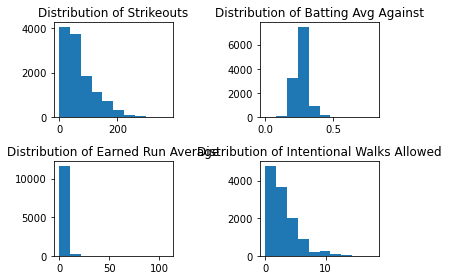

In [450]:
plt.subplot(2,2,1)
plt.hist(pitchers['SO'])
plt.title('Distribution of Strikeouts');

plt.subplot(2,2,2)
plt.hist(pitchers['BAOpp'])
plt.title('Distribution of Batting Avg Against');

plt.subplot(2,2,3)
plt.hist(pitchers['ERA'])
plt.title('Distribution of Earned Run Average');

plt.subplot(2,2,4)
plt.hist(pitchers['IBB'])
plt.title('Distribution of Intentional Walks Allowed');

plt.tight_layout()
plt.savefig('pitchers4.png')

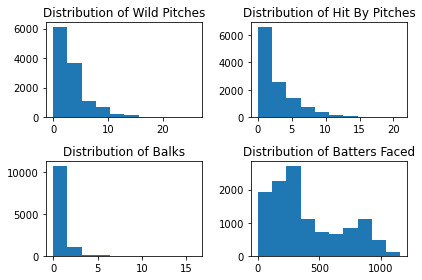

In [451]:
plt.subplot(2,2,1)
plt.hist(pitchers['WP'])
plt.title('Distribution of Wild Pitches');

plt.subplot(2,2,2)
plt.hist(pitchers['HBP'])
plt.title('Distribution of Hit By Pitches');

plt.subplot(2,2,3)
plt.hist(pitchers['BK'])
plt.title('Distribution of Balks');

plt.subplot(2,2,4)
plt.hist(pitchers['BFP'])
plt.title('Distribution of Batters Faced');

plt.tight_layout()
plt.savefig('pitchers5.png')

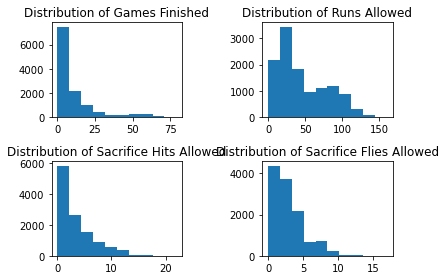

In [452]:
plt.subplot(2,2,1)
plt.hist(pitchers['GF'])
plt.title('Distribution of Games Finished');

plt.subplot(2,2,2)
plt.hist(pitchers['R'])
plt.title('Distribution of Runs Allowed');

plt.subplot(2,2,3)
plt.hist(pitchers['SH'])
plt.title('Distribution of Sacrifice Hits Allowed');

plt.subplot(2,2,4)
plt.hist(pitchers['SF'])
plt.title('Distribution of Sacrifice Flies Allowed');

plt.tight_layout()
plt.savefig('pitchers6.png')

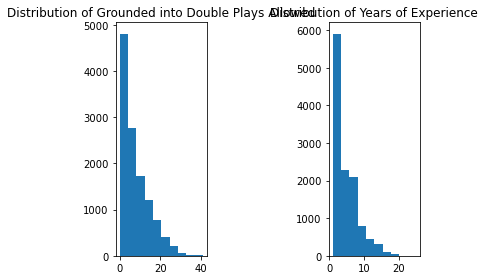

In [453]:
plt.subplot(1,2,1)
plt.hist(pitchers['GIDP'])
plt.title('Distribution of Grounded into Double Plays Allowed');

plt.subplot(1,2,2)
plt.hist(pitchers['Years_Exp'])
plt.title('Distribution of Years of Experience');

plt.tight_layout()
plt.savefig('pitchers7.png')

#### Target Variable Distribution

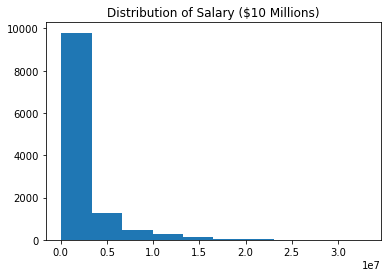

In [454]:
plt.hist(pitchers['salary'])
plt.title('Distribution of Salary ($10 Millions)');
plt.savefig('pitchers_target.png')
# May want to use np.log since the distribution is heavily skewed to the right

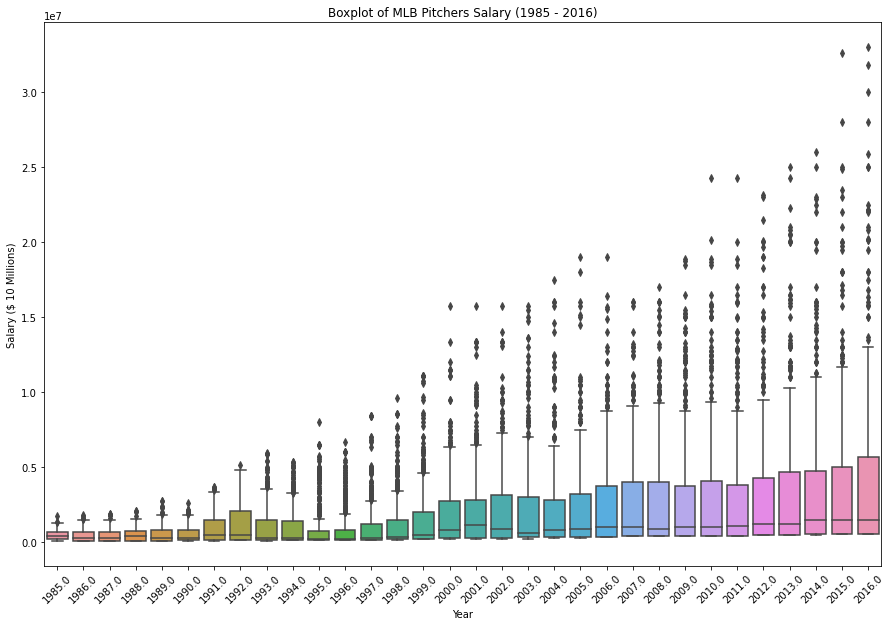

In [455]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='yearID', y='salary', data=pitchers)
plt.title('Boxplot of MLB Pitchers Salary (1985 - 2016)')
plt.xlabel('Year')
plt.ylabel('Salary ($ 10 Millions)')
plt.xticks(rotation=45);
plt.savefig('pitchers_year_salary.png')

### Adding more standard baseball stats as features

In [324]:
pitchers['WHIP'] = (pitchers['BB'] + pitchers['H']) / (pitchers['IPouts'] / 3)
pitchers['H_per_9'] = (9 * pitchers['H']) / (pitchers['IPouts'] / 3)
pitchers['HR_per_9'] = (9 * pitchers['HR']) / (pitchers['IPouts'] / 3)
pitchers['BB_per_9'] = (9 * pitchers['BB']) / (pitchers['IPouts'] / 3)
pitchers['SO_per_9'] = (9 * pitchers['SO']) / (pitchers['IPouts'] / 3)


In [383]:
pitchers.columns = pitchers.columns.str.replace(' ', '_')
pitchers.columns = pitchers.columns.str.replace('-', '')

In [446]:
pitchers[pitchers['playerID']=='degroja01']

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS_MVP,awardID_AllStar_Game_MVP,awardID_Gold_Glove,awardID_Most_Valuable_Player,awardID_NLCS_MVP,awardID_Rookie_of_the_Year,awardID_World_Series_MVP,awardID_Cy_Young_Award,awardID_Rolaids_Relief_Man_Award,awardID_Pitching_Triple_Crown,awardID_Reliever_of_the_Year_Award,WHIP,H_per_9,HR_per_9,BB_per_9,SO_per_9
11864,degroja01,2015.0,1.0,NYN,NL,14.0,8.0,30.0,30.0,0.0,0.0,0.0,573.0,149.0,54.0,16.0,38.0,205.0,0.215,2.54,2.0,6.0,2.0,0.0,751.0,0.0,59.0,10.0,7.0,8.0,556875,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979058,7.020942,0.753927,1.790576,9.659686
11865,degroja01,2016.0,1.0,NYN,NL,7.0,8.0,24.0,24.0,1.0,1.0,0.0,444.0,142.0,50.0,15.0,36.0,143.0,0.255,3.04,0.0,4.0,3.0,0.0,604.0,0.0,53.0,5.0,3.0,15.0,607000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.202703,8.635135,0.912162,2.189189,8.695946


In [384]:
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS_MVP,awardID_AllStar_Game_MVP,awardID_Gold_Glove,awardID_Most_Valuable_Player,awardID_NLCS_MVP,awardID_Rookie_of_the_Year,awardID_World_Series_MVP,awardID_Cy_Young_Award,awardID_Rolaids_Relief_Man_Award,awardID_Pitching_Triple_Crown,awardID_Reliever_of_the_Year_Award,WHIP,H_per_9,HR_per_9,BB_per_9,SO_per_9
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.645833,12.375000,1.125000,2.437500,1.500000
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.245283,9.297170,1.018868,1.910377,3.566038
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.380107,10.166963,0.575488,2.253996,3.021314
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.514178,11.279773,0.561437,2.347826,4.134216
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.468182,8.304545,1.186364,4.909091,6.095455


### Jointplots of the new baseball stats compared with salary

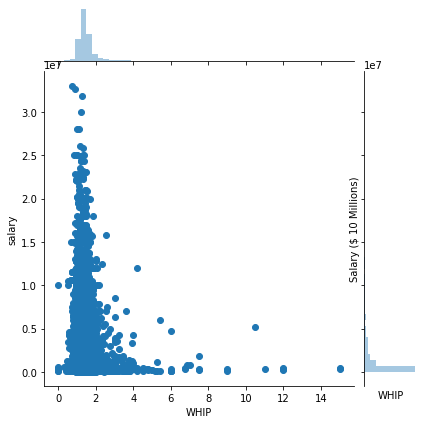

In [456]:
sns.jointplot(
    pitchers['WHIP'],
    pitchers['salary']
);
plt.xlabel('WHIP')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_whip_salary.png')

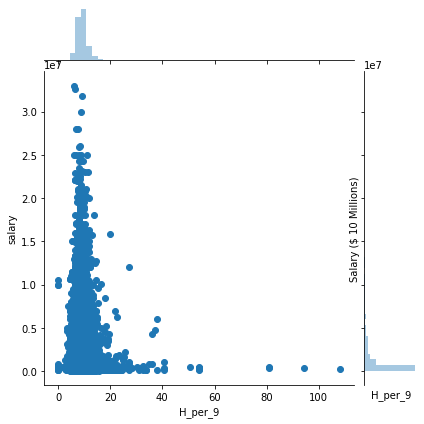

In [457]:
sns.jointplot(
    pitchers['H_per_9'],
    pitchers['salary']
);
plt.xlabel('H_per_9')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_h9_salary.png')

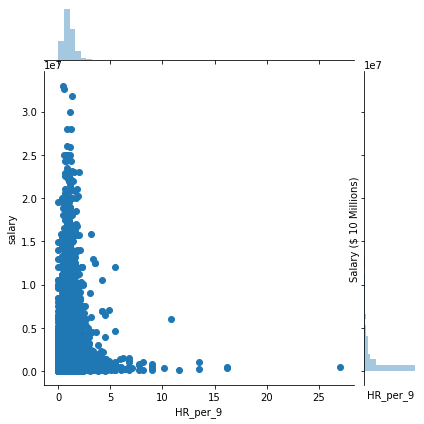

In [458]:
sns.jointplot(
    pitchers['HR_per_9'],
    pitchers['salary']
);
plt.xlabel('HR_per_9')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_hr9_salary.png')

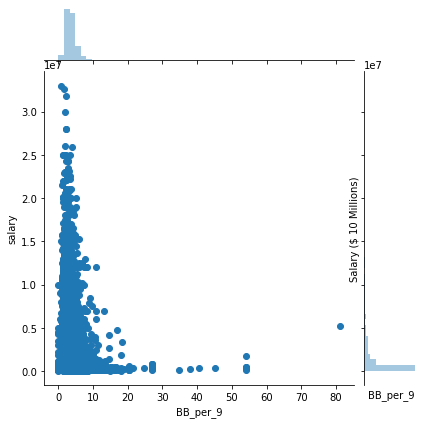

In [459]:
sns.jointplot(
    pitchers['BB_per_9'],
    pitchers['salary']
);
plt.xlabel('BB_per_9')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_bb9_salary.png')

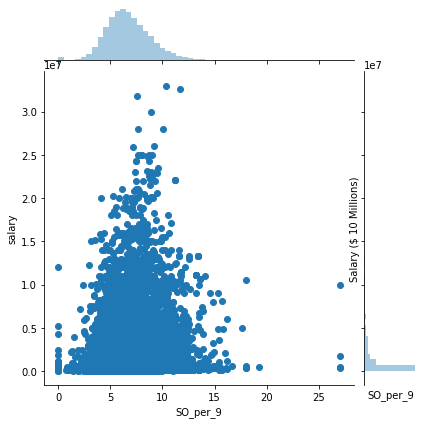

In [460]:
sns.jointplot(
    pitchers['SO_per_9'],
    pitchers['salary']
);
plt.xlabel('SO_per_9')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_k9_salary.png')

### Boxplot of Salary vs All Star Status

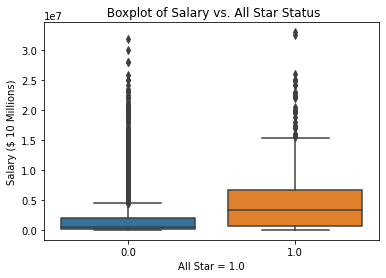

In [461]:
sns.boxplot(x='allStar', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. All Star Status')
plt.xlabel('All Star = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_allstar.png')

### Boxplots of Salary vs Award Winners

In [391]:
pitchers.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS_MVP,awardID_AllStar_Game_MVP,awardID_Gold_Glove,awardID_Most_Valuable_Player,awardID_NLCS_MVP,awardID_Rookie_of_the_Year,awardID_World_Series_MVP,awardID_Cy_Young_Award,awardID_Rolaids_Relief_Man_Award,awardID_Pitching_Triple_Crown,awardID_Reliever_of_the_Year_Award,WHIP,H_per_9,HR_per_9,BB_per_9,SO_per_9
0,johnto01,1985.0,2.0,OAK,AL,2.0,6.0,11.0,11.0,0.0,0.0,0.0,144.0,66.0,33.0,6.0,13.0,8.0,0.332,6.19,0.0,2.0,1.0,0.0,221.0,0.0,37.0,6.0,2.0,4.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.645833,12.375000,1.125000,2.437500,1.500000
1,johnto01,1986.0,1.0,NYA,AL,5.0,3.0,13.0,10.0,1.0,0.0,0.0,212.0,73.0,23.0,8.0,15.0,28.0,0.275,2.93,1.0,2.0,2.0,0.0,290.0,2.0,27.0,5.0,3.0,10.0,60000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.245283,9.297170,1.018868,1.910377,3.566038
2,johnto01,1987.0,1.0,NYA,AL,13.0,6.0,33.0,33.0,3.0,1.0,0.0,563.0,212.0,84.0,12.0,47.0,63.0,0.288,4.03,7.0,9.0,6.0,0.0,802.0,0.0,95.0,12.0,1.0,27.0,350000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.380107,10.166963,0.575488,2.253996,3.021314
3,johnto01,1988.0,1.0,NYA,AL,9.0,8.0,35.0,32.0,0.0,0.0,0.0,529.0,221.0,88.0,11.0,46.0,81.0,0.308,4.49,4.0,5.0,6.0,5.0,776.0,2.0,96.0,5.0,2.0,29.0,375000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.514178,11.279773,0.561437,2.347826,4.134216
4,niekrph01,1985.0,1.0,NYA,AL,16.0,12.0,33.0,33.0,7.0,1.0,0.0,660.0,203.0,100.0,29.0,120.0,149.0,0.245,4.09,1.0,5.0,2.0,2.0,955.0,0.0,110.0,1.0,3.0,27.0,600000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.468182,8.304545,1.186364,4.909091,6.095455


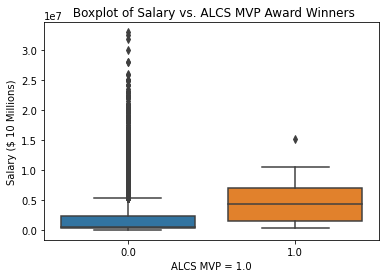

In [462]:
sns.boxplot(x='awardID_ALCS_MVP', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. ALCS MVP Award Winners')
plt.xlabel('ALCS MVP = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_alcs_mvp.png')

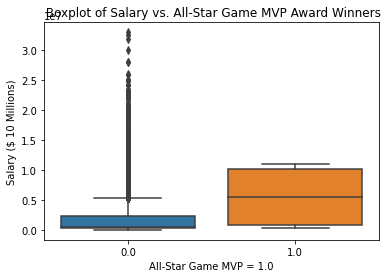

In [463]:
sns.boxplot(x='awardID_AllStar_Game_MVP', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. All-Star Game MVP Award Winners')
plt.xlabel('All-Star Game MVP = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_allstar_mvp.png')

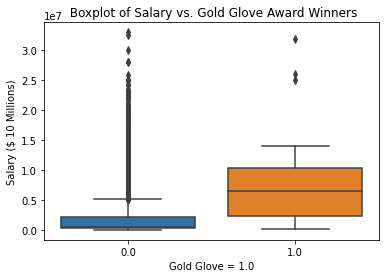

In [464]:
sns.boxplot(x='awardID_Gold_Glove', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Gold Glove Award Winners')
plt.xlabel('Gold Glove = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_goldglove.png')

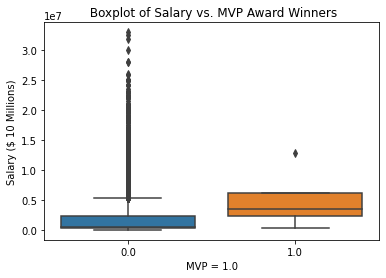

In [465]:
sns.boxplot(x='awardID_Most_Valuable_Player', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. MVP Award Winners')
plt.xlabel('MVP = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_mvp.png')

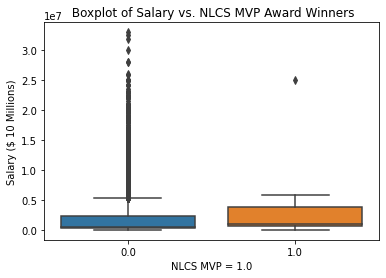

In [466]:
sns.boxplot(x='awardID_NLCS_MVP', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. NLCS MVP Award Winners')
plt.xlabel('NLCS MVP = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_nlcs_mvp.png')

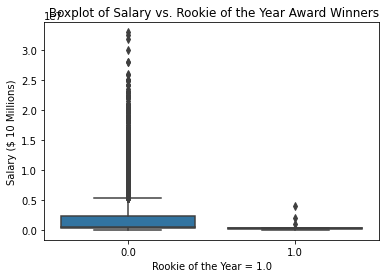

In [467]:
sns.boxplot(x='awardID_Rookie_of_the_Year', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Rookie of the Year Award Winners')
plt.xlabel('Rookie of the Year = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_roy.png')

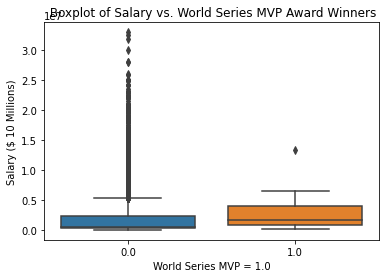

In [468]:
sns.boxplot(x='awardID_World_Series_MVP', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. World Series MVP Award Winners')
plt.xlabel('World Series MVP = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_ws_mvp.png')

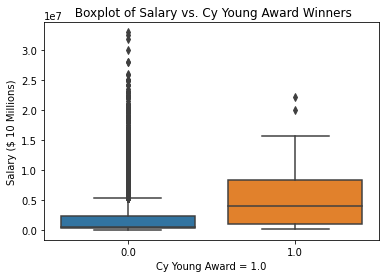

In [469]:
sns.boxplot(x='awardID_Cy_Young_Award', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Cy Young Award Winners')
plt.xlabel('Cy Young Award = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_cy_young.png')

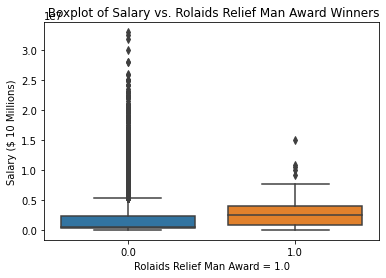

In [470]:
sns.boxplot(x='awardID_Rolaids_Relief_Man_Award', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Rolaids Relief Man Award Winners')
plt.xlabel('Rolaids Relief Man Award = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_rolaids_relief.png')

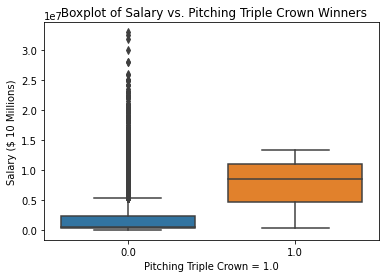

In [471]:
sns.boxplot(x='awardID_Pitching_Triple_Crown', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Pitching Triple Crown Winners')
plt.xlabel('Pitching Triple Crown = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_triple_crown.png')

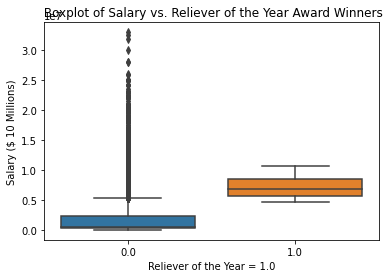

In [472]:
sns.boxplot(x='awardID_Reliever_of_the_Year_Award', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Reliever of the Year Award Winners')
plt.xlabel('Reliever of the Year = 1.0')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_reliever.png')

### Boxplot of Salary vs Years of Experience

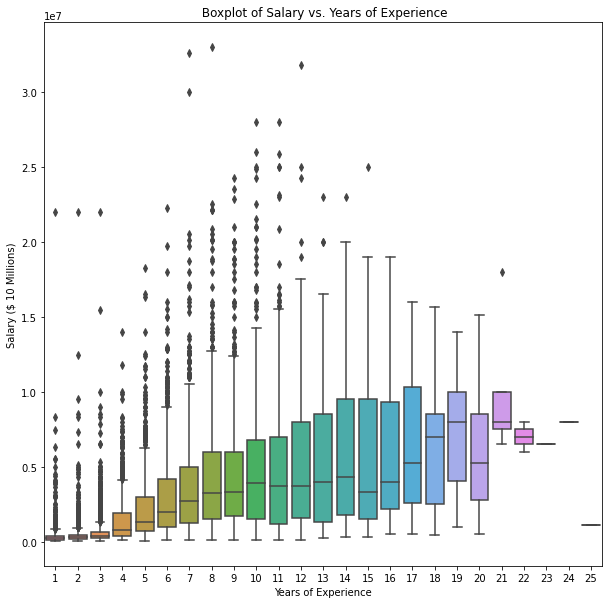

In [473]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='Years_Exp', y='salary', data=pitchers)
plt.title(' Boxplot of Salary vs. Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary ($ 10 Millions)');
plt.savefig('pitchers_exp_salary.png')

### Correlation

In [405]:
pitchers.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS_MVP,awardID_AllStar_Game_MVP,awardID_Gold_Glove,awardID_Most_Valuable_Player,awardID_NLCS_MVP,awardID_Rookie_of_the_Year,awardID_World_Series_MVP,awardID_Cy_Young_Award,awardID_Rolaids_Relief_Man_Award,awardID_Pitching_Triple_Crown,awardID_Reliever_of_the_Year_Award,WHIP,H_per_9,HR_per_9,BB_per_9,SO_per_9
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.00000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,2001.258167,1.008667,5.424333,5.079583,34.623833,10.659417,0.75400,0.244583,3.10325,277.757250,91.239167,41.647750,9.898000,32.829500,68.818167,0.265459,4.66195,2.658583,3.21075,3.018250,0.479583,395.45225,9.484917,45.571083,3.45025,2.818917,7.839250,1.997539e+06,4.578083,0.078917,0.001083,0.000333,0.005250,0.000333,0.001250,0.001167,0.001250,0.005333,0.004667,0.000750,0.000500,1.458286,9.377264,1.058355,3.747312,6.763083
std,8.864389,0.101287,5.166333,4.057785,20.185101,12.985009,1.90922,0.721207,8.79428,206.631564,67.352681,30.395775,8.108611,23.042457,55.259443,0.052352,3.25200,2.521352,3.07649,3.015019,1.009456,287.09148,14.369927,33.168184,3.26199,2.448733,6.753842,3.252390e+06,3.592396,0.269620,0.032898,0.018255,0.072269,0.018255,0.035335,0.034138,0.035335,0.072838,0.068156,0.027377,0.022356,0.506052,3.187232,0.803430,2.352641,2.253700
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.00000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,1.000000,1.000000,2.000000,20.000000,0.000000,0.00000,0.000000,0.00000,119.000000,39.000000,18.000000,4.000000,15.000000,28.000000,0.236000,3.28000,1.000000,1.00000,1.000000,0.000000,175.75000,0.000000,19.000000,1.00000,1.000000,3.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.230508,7.915784,0.656999,2.623326,5.269776
50%,2001.000000,1.000000,4.000000,4.000000,32.000000,2.000000,0.00000,0.000000,0.00000,212.000000,67.000000,31.000000,7.000000,27.000000,55.000000,0.262000,4.16000,2.000000,2.00000,2.000000,0.000000,301.00000,3.000000,34.000000,3.00000,2.000000,6.000000,5.500000e+05,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.386647,9.000000,0.944206,3.380290,6.545455
75%,2009.000000,1.000000,8.000000,8.000000,49.000000,23.000000,1.00000,0.000000,1.00000,427.000000,146.000000,66.000000,15.000000,46.250000,95.000000,0.288000,5.26000,4.000000,5.00000,4.000000,1.000000,619.00000,13.000000,73.000000,5.00000,4.000000,12.000000,2.300000e+06,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.571007,10.230053,1.296000,4.361538,8.080292
max,2016.000000,4.000000,27.000000,21.000000,94.000000,39.000000,20.00000,10.000000,62.00000,845.000000,284.000000,145.000000,50.000000,152.000000,372.000000,0.800000,108.00000,18.000000,26.00000,21.000000,16.000000,1157.00000,79.000000,160.000000,22.00000,17.000000,41.000000,3.300000e+07,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000

In [406]:
pitchers.corr()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary,Years_Exp,allStar,awardID_ALCS_MVP,awardID_AllStar_Game_MVP,awardID_Gold_Glove,awardID_Most_Valuable_Player,awardID_NLCS_MVP,awardID_Rookie_of_the_Year,awardID_World_Series_MVP,awardID_Cy_Young_Award,awardID_Rolaids_Relief_Man_Award,awardID_Pitching_Triple_Crown,awardID_Reliever_of_the_Year_Award,WHIP,H_per_9,HR_per_9,BB_per_9,SO_per_9
yearID,1.000000,-0.047604,-0.081474,-0.087886,0.072369,-0.060793,-0.261769,-0.170156,-0.007376,-0.102218,-0.103192,-0.091304,-0.022934,-0.148789,0.024746,-0.037095,0.010708,-0.219391,-0.042588,0.084647,-0.248001,-0.105599,-0.018357,-0.104011,-0.177073,-0.136418,-0.071428,0.341357,0.165920,0.015187,0.001041,-0.011347,-0.004458,-0.001047,-0.011939,0.001759,-0.019922,-0.006263,-0.021306,0.001606,0.034674,-0.026417,-0.013898,0.073049,-0.032312,0.291245
stint,-0.047604,1.000000,-0.056719,-0.063524,-0.073858,-0.047308,-0.027761,-0.023316,-0.023366,-0.067558,-0.067739,-0.068713,-0.061330,-0.066142,-0.066143,0.021081,0.020516,-0.045522,-0.040096,-0.051278,-0.023538,-0.068862,-0.028425,-0.068230,-0.043846,-0.050459,-0.056076,-0.030062,0.010508,-0.025047,-0.002818,-0.001563,-0.006216,-0.001563,-0.003027,-0.002924,-0.003027,-0.006266,-0.005859,-0.002344,-0.001914,0.038005,0.048735,-0.009320,0.007549,-0.015755
W,-0.081474,-0.056719,1.000000,0.636707,0.104302,0.831443,0.631475,0.567515,-0.115985,0.910486,0.851022,0.759548,0.712527,0.745236,0.861213,-0.244008,-0.252683,0.243611,0.476755,0.541092,0.276107,0.897869,-0.228759,0.762663,0.604976,0.567363,0.749798,0.285532,0.125312,0.376162,0.048292,0.041800,0.144031,0.047985,0.062378,0.026963,0.066944,0.194195,-0.016512,0.086135,-0.014825,-0.306504,-0.223985,-0.166827,-0.289918,0.011443
L,-0.087886,-0.063524,0.636707,1.000000,0.059102,0.808950,0.440894,0.340606,-0.088407,0.815793,0.855398,0.875575,0.781459,0.775095,0.678522,-0.062929,-0.128151,0.308253,0.489903,0.554475,0.270907,0.834945,-0.206823,0.880945,0.631088,0.634578,0.708242,0.213129,0.086300,0.098010,0.007470,-0.002608,0.076159,-0.008234,0.024300,0.004744,0.019069,0.022532,-0.026354,0.001713,-0.016056,-0.185437,-0.093420,-0.066062,-0.232426,-0.117488
G,0.072369,-0.073858,0.104302,0.059102,1.000000,-0.216552,-0.065304,-0.055720,0.467973,0.110425,0.049450,-0.009180,-0.007802,0.117205,0.186127,-0.409622,-0.358078,0.402724,0.140769,0.070672,0.010908,0.100032,0.679937,-0.004616,0.124535,0.078696,0.087416,-0.016188,0.086739,0.133230,0.008395,0.004638,-0.008987,0.005542,0.005216,0.028333,0.002061,0.003009,0.113831,-0.001299,0.036615,-0.353144,-0.360074,-0.268538,-0.195841,0.308332
GS,-0.060793,-0.047308,0.831443,0.808950,-0.216552,1.000000,0.585859,0.504441,-0.277945,0.927470,0.935227,0.912702,0.838872,0.811218,0.803639,-0.057017,-0.114708,0.143992,0.493733,0.596940,0.292948,0.934386,-0.489114,0.914788,0.634778,0.641446,0.784802,0.292801,0.101307,0.214087,0.026812,0.017707,0.119311,0.018058,0.046701,0.004281,0.044703,0.114445,-0.056212,0.048075,-0.018361,-0.175618,-0.076925,-0.053470,-0.235763,-0.141493
CG,-0.261769,-0.027761,0.631475,0.440894,-0.065304,0.585859,1.000000,0.786592,-0.135016,0.645815,0.585356,0.495029,0.438549,0.483767,0.579408,-0.125367,-0.127766,0.137431,0.311813,0.280814,0.287768,0.628167,-0.246684,0.504966,0.417837,0.379331,0.509627,0.096734,0.019849,0.319423,0.026801,0.047786,0.139223,0.040612,0.057679,-0.000711,0.078681,0.195817,-0.027043,0.073686,-0.008833,-0.164473,-0.109499,-0.100894,-0.170060,-0.052227
SHO,-0.170156,-0.023316,0.567515,0.340606,-0.055720,0.504441,0.786592,1.000000,-0.116079,0.551945,0.480623,0.389198,0.340137,0.402452,0.523147,-0.133036,-0.123478,0.123243,0.244240,0.259222,0.228654,0.531969,-0.212790,0.396067,0.364367,0.288639,0.425346,0.116643,0.030633,0.319463,0.038008,0.025458,0.104878,0.025458,0.073031,0.015489,0.056679,0.202035,-0.023222,0.087790,-0.007585,-0.156234,-0.111966,-0.101669,-0.150767,-0.013307
SV,-0.007376,-0.023366,-0.115985,-0.088407,0.467973,-0.2779

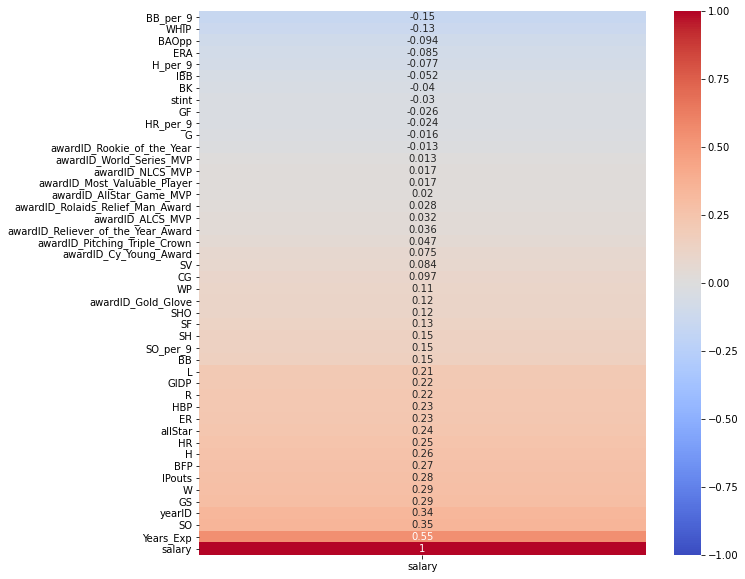

In [474]:
plt.figure(figsize=(10,10))
sns.heatmap(pitchers.corr()[['salary']].sort_values('salary'),
           annot=True,
           vmin=-1,
           vmax=1,
           cmap='coolwarm');
plt.savefig('pitchers_heatmap.png')

## Modeling - Linear Regression

In [408]:
X = pitchers.drop(columns=['salary', 'playerID', 'stint', 'teamID', 'lgID'])
y = pitchers['salary']
print(X.shape)
print(y.shape)

(12000, 44)
(12000,)


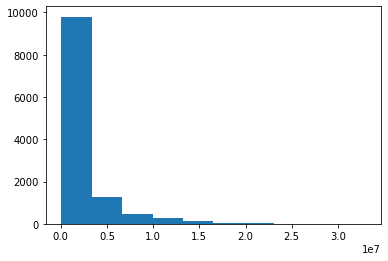

In [409]:
# Heavily right skewed - may want to log transform our target
plt.hist(y);

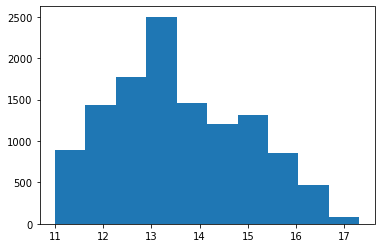

In [477]:
plt.hist(np.log(y));
plt.savefig('pitchers_target_log.png')

### Train Test Split

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=23)

In [411]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

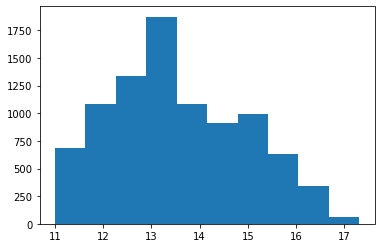

In [475]:
plt.hist(y_train_log);

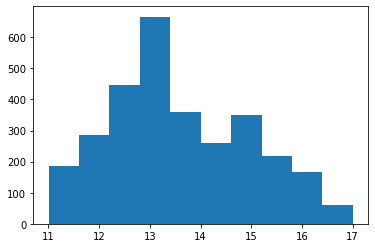

In [413]:
plt.hist(y_test_log);

In [414]:
# Instantiate Linear Regression Model
lr = LinearRegression()

In [415]:
# Fit the model on training data
lr.fit(X_train, y_train_log)

LinearRegression()

In [416]:
# R2 scores on training and testing data
lr.score(X_train, y_train_log), lr.score(X_test, y_test_log)

(0.6755306336658073, 0.6733022148208878)

In [417]:
pred_lr = lr.predict(X_test)

In [418]:
pred_lr

array([15.22675205, 13.05476353, 12.85598199, ..., 14.1167315 ,
       13.96499643, 13.02109998])

In [419]:
# RMSE
np.sqrt(mean_squared_error(y_test, np.exp(pred_lr)))

2949341.9605279407

In [420]:
resids = y_test_log - pred_lr

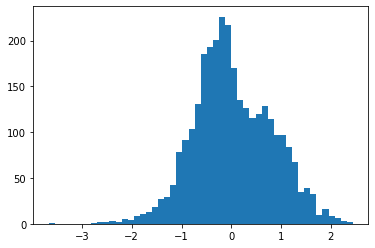

In [421]:
plt.hist(resids, bins=50);

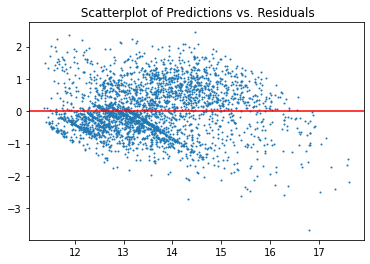

In [478]:
# Plot a scatter of predctions vs residuals.
plt.scatter(pred_lr, resids, s=1)
plt.axhline(0, color="red");
plt.title(' Scatterplot of Predictions vs. Residuals');
plt.savefig('pitchers_scatter.png')

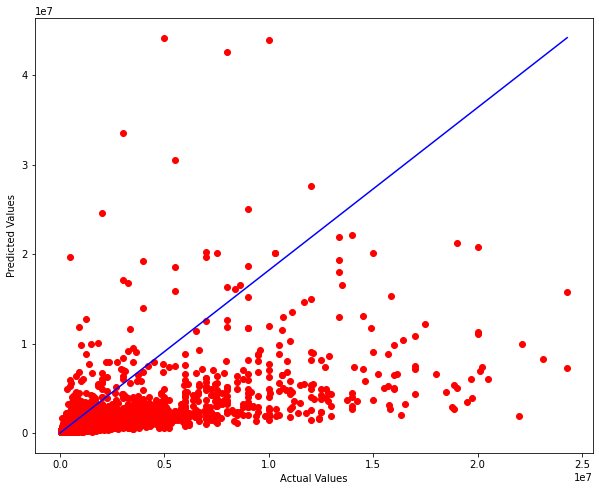

In [423]:
# Plot predicted target values vs actual on scatterplot
plt.figure(figsize=(10,8))
plt.scatter(np.exp(y_test_log), np.exp(pred_lr), color = 'red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0,np.max(np.exp(y_test_log))],[0,np.max(np.exp(pred_lr))], color = 'blue');

In [424]:
np.exp(lr.coef_)

array([1.06221405, 1.01091855, 1.02705834, 0.99335095, 1.01231488,
       1.06526315, 0.96879644, 1.00854271, 0.99813052, 0.99841458,
       1.00922763, 0.99051896, 0.99466309, 1.00302132, 0.90118195,
       0.99890878, 1.01134153, 0.99814945, 0.99432113, 0.96755826,
       1.00176296, 1.01267569, 0.99468921, 1.00038163, 0.99173391,
       1.00128416, 1.23717799, 1.14915427, 1.53106273, 0.64824085,
       1.02685381, 0.75189457, 1.09570849, 0.66105839, 1.10146987,
       0.93949595, 1.1814523 , 0.88147988, 1.77665886, 0.99978326,
       0.99959599, 1.00109524, 0.99845439, 1.01256563])

In [443]:
coef_df = pd.DataFrame({
    'Features': X.columns,
    'Coef Value': np.exp(lr.coef_)
})

In [444]:
coef_df['Features'].values

array(['yearID', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H',
       'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK',
       'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP', 'Years_Exp', 'allStar',
       'awardID_ALCS_MVP', 'awardID_AllStar_Game_MVP',
       'awardID_Gold_Glove', 'awardID_Most_Valuable_Player',
       'awardID_NLCS_MVP', 'awardID_Rookie_of_the_Year',
       'awardID_World_Series_MVP', 'awardID_Cy_Young_Award',
       'awardID_Rolaids_Relief_Man_Award',
       'awardID_Pitching_Triple_Crown',
       'awardID_Reliever_of_the_Year_Award', 'WHIP', 'H_per_9',
       'HR_per_9', 'BB_per_9', 'SO_per_9'], dtype=object)

In [426]:
coef_df

,Features,Coef Value
0,yearID,1.062214
1,W,1.010919
2,L,1.027058
3,G,0.993351
4,GS,1.012315
5,CG,1.065263
6,SHO,0.968796
7,SV,1.008543
8,IPouts,0.998131
9,H,0.998415


In [427]:
# Poly features with simple linear regression model
#AdaBoost and Gradient Boost
# Flask

### AdaBoost Model

In [428]:
ada = AdaBoostRegressor(base_estimator = LinearRegression())
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [.9, 1.0],
    'random_state': [None, 42]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=5)
gs.fit(X_train, y_train_log)
print(gs.best_score_)
gs.best_params_

0.6577486365711624


{'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}

In [429]:
gs.score(X_test, y_test_log)

0.6615029350793376

### Gradient Boosting Model

In [430]:
gboost = GradientBoostingRegressor()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(gboost, param_grid=gboost_params, cv=5)
gb_gs.fit(X_train, y_train_log)
print(gb_gs.best_score_)
gb_gs.best_params_

0.8069022930371649


{'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 125}

In [431]:
gb_gs.score(X_test, y_test_log)

0.8047405986753013

In [432]:
# ELI5
# Poly features
# Scale
# Lasso
# Ridge

### Feature Engineering - Polynomial Features

In [433]:
# Polynomial Features create interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train_poly.shape)
X_test_poly.shape

(9000, 1034)


(3000, 1034)

### Feature Engineering - Standard Scaler

In [434]:
ss = StandardScaler()

X_train_poly_sc = ss.fit_transform(X_train_poly)
X_test_poly_sc = ss.transform(X_test_poly)

### Lasso Regression Model

In [435]:
lcv = LassoCV()
lcv.fit(X_train_poly_sc, y_train_log)
lcv.score(X_train_poly_sc, y_train_log), lcv.score(X_test_poly_sc, y_test_log)

/Users/brandonhoskins/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4379849865936194, tolerance: 1.3671280112254571
  model = cd_fast.enet_coordinate_descent_gram(
/Users/brandonhoskins/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3619083132671221, tolerance: 1.3494291449421925
  model = cd_fast.enet_coordinate_descent_gram(
/Users/brandonhoskins/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2807325782332555, tolerance: 1.3494291449421925
  model = cd_fast.enet_coordinate_descent_gram(
/Users/brandonhoskins/opt

(0.7613206790136388, 0.7433474959784583)

In [436]:
# From Regularization Review lesson
coef_df = pd.DataFrame({
    'var': poly.get_feature_names(X.columns),
    'coef val': lcv.coef_
}).set_index('var').sort_values('coef val', ascending=False)

In [437]:
coef_df[coef_df['coef val'] != 0]

,coef val
var,
Years_Exp,1.398231
yearID,0.327107
GS Years_Exp,0.324564
SV,0.277256
GS SO_per_9,0.239533
yearID^2,0.205778
IPouts^2,0.202676
Years_Exp SO_per_9,0.188078
GS,0.174985


### Pickling Linear Regression Model to Use in Flask

In [438]:
with open('pitchers.p','wb') as pickle_out:
    pickle.dump(lr, pickle_out)

In [439]:
with open('pitchers.p', 'rb') as pickle_in:
    lr = pickle.load(pickle_in)

In [440]:
lr.score(X_train, y_train_log), lr.score(X_test, y_test_log)

(0.6755306336658073, 0.6733022148208878)

### Ridge Regression Model

In [441]:
rcv = RidgeCV()
rcv.fit(X_train_poly_sc, y_train_log)
rcv.score(X_train_poly_sc, y_train_log), rcv.score(X_test_poly_sc, y_test_log)

(0.7726065512681637, 0.6976294682684232)